# Render a Nerfie video!

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook renders a figure-8 orbit video using the test cameras generated in the capture processing notebook.

You can also load your own custom cameras by modifying the code slightly.

### Instructions

1. Convert a video into our dataset format using the [capture processing notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Capture_Processing.ipynb).
2. Train a Nerfie model using the [training notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb)
3. Run this notebook!


### Notes
 * Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).

In [1]:
# @title Define imports and utility functions.

import jax
from jax.config import config as jax_config
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import flax
import flax.linen as nn
from flax import jax_utils
from flax import optim
from flax.metrics import tensorboard
from flax.training import checkpoints
jax_config.enable_omnistaging() # Linen requires enabling omnistaging

from absl import logging
from io import BytesIO
import random as pyrandom
import numpy as np
import PIL
import IPython
import tempfile
import imageio
from IPython.display import display, HTML
from base64 import b64encode


# Monkey patch logging.
def myprint(msg, *args, **kwargs):
 print(msg % args)

logging.info = myprint 
logging.warn = myprint
logging.error = myprint


def show_image(image, fmt='png'):
    image = image_utils.image_to_uint8(image)
    f = BytesIO()
    PIL.Image.fromarray(image).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))


def show_video(frames, fps=30):
  with tempfile.NamedTemporaryFile(suffix='.mp4') as f:
    with imageio.get_writer(f.name, fps=fps) as writer:
      for frame in frames:
        writer.append_data(frame)

    with open(f.name,'rb') as f:
      data_url = "data:video/mp4;base64," + b64encode(f.read()).decode()
    display(HTML("""
    <video controls autoplay loop>
      <source src="%s" type="video/mp4">
    </video>
    """ % data_url))


/private/home/gengshany/.conda/envs/nerfies/lib/python3.8/site-packages/jax/_src/config.py:163: UserWarning: enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;
see https://github.com/google/jax/blob/main/design_notes/omnistaging.md
  warnings.warn(


In [2]:
import os
os.chdir('/private/home/gengshany/code/vid2shape/third_party/nerfies-0.1/')

In [5]:
# @title Model and dataset configuration
# @markdown Change the directories to where you saved your capture and experiment.

import sys
sys.path.insert(0,'/private/home/gengshany/code/vid2shape/third_party/nerfies-0.1/')
from pathlib import Path
from pprint import pprint
import gin
from IPython.display import display, Markdown

from nerfies import configs

#seqname='cat_905_nort'
#seqname='T_swing1'
#seqname='T_samba'
seqname='a-hands-1'
#seqname='a-eagle-1'
# @markdown The working directory where the trained model is.
train_dir = './logs/%s/'%(seqname)  # @param {type: "string"}
#train_dir = './logs/'  # @param {type: "string"}
# @markdown The directory to the dataset capture.
data_dir = 'dataset/%s/'%(seqname)  # @param {type: "string"}

checkpoint_dir = Path(train_dir, 'checkpoints')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

config_path = '%s/config.gin'%(train_dir)
with open(config_path, 'r') as f:
  logging.info('Loading config from %s', config_path)
  config_str = f.read()
gin.parse_config(config_str)

config_path = Path(train_dir, 'config.gin')
with open(config_path, 'w') as f:
  logging.info('Saving config to %s', config_path)
  f.write(config_str)

exp_config = configs.ExperimentConfig()
model_config = configs.ModelConfig()
train_config = configs.TrainConfig()
eval_config = configs.EvalConfig()

display(Markdown(
    gin.config.markdownify_operative_config_str(gin.operative_config_str())))

Loading config from ./logs/a-hands-1//config.gin
Saving config to logs/a-hands-1/config.gin


#### Macros:

    ANNEALED_WARP_ALPHA_SCHED = \
        {'final_value': %num_warp_freqs,
         'initial_value': 0.0,
         'num_steps': 80000,
         'type': 'linear'}
    batch_size = 4096
    DECAYING_ELASTIC_LOSS_SCHED = \
        {'schedules': [(50000, ('constant', %elastic_init_weight)),
                       (100000,
                        ('cosine_easing', %elastic_init_weight, 1e-08, 100000))],
         'type': 'piecewise'}
    elastic_init_weight = 0.01
    final_lr = 0.0001
    image_scale = 4
    init_lr = 0.001
    lr_decay_steps = 500000
    max_steps = 250000
    num_warp_freqs = 8
    
#### Parameters for EvalConfig:

    EvalConfig.chunk = 8192
    EvalConfig.eval_once = False
    EvalConfig.num_test_eval = 10
    EvalConfig.num_train_eval = 10
    EvalConfig.num_val_eval = None
    EvalConfig.save_output = True
    
#### Parameters for ExperimentConfig:

    ExperimentConfig.datasource_spec = None
    ExperimentConfig.datasource_type = 'nerfies'
    ExperimentConfig.image_scale = %image_scale
    ExperimentConfig.random_seed = 12345
    ExperimentConfig.subname = None
    
#### Parameters for ModelConfig:

    ModelConfig.alpha_channels = 1
    ModelConfig.appearance_metadata_dims = 8
    ModelConfig.camera_metadata_dims = 2
    ModelConfig.nerf_condition_depth = 1
    ModelConfig.nerf_condition_width = 128
    ModelConfig.nerf_skips = (4,)
    ModelConfig.nerf_trunk_depth = 8
    ModelConfig.nerf_trunk_width = 256
    ModelConfig.noise_std = None
    ModelConfig.num_coarse_samples = 128
    ModelConfig.num_fine_samples = 128
    ModelConfig.num_nerf_point_freqs = 8
    ModelConfig.num_nerf_viewdir_freqs = 4
    ModelConfig.num_warp_features = 8
    ModelConfig.num_warp_freqs = %num_warp_freqs
    ModelConfig.rgb_channels = 3
    ModelConfig.sigma_activation = @nn.softplus
    ModelConfig.use_appearance_metadata = True
    ModelConfig.use_camera_metadata = False
    ModelConfig.use_linear_disparity = False
    ModelConfig.use_sample_at_infinity = True
    ModelConfig.use_stratified_sampling = True
    ModelConfig.use_viewdirs = True
    ModelConfig.use_warp = True
    ModelConfig.use_white_background = False
    ModelConfig.warp_field_type = 'se3'
    
#### Parameters for TrainConfig:

    TrainConfig.background_loss_weight = 1.0
    TrainConfig.background_points_batch_size = 16384
    TrainConfig.batch_size = %batch_size
    TrainConfig.elastic_loss_weight_schedule = %DECAYING_ELASTIC_LOSS_SCHED
    TrainConfig.elastic_reduce_method = 'weight'
    TrainConfig.log_every = 500
    TrainConfig.lr_schedule = \
        {'final_value': %final_lr,
         'initial_value': %init_lr,
         'num_steps': %lr_decay_steps,
         'type': 'exponential'}
    TrainConfig.max_steps = %max_steps
    TrainConfig.print_every = 200
    TrainConfig.save_every = 5000
    TrainConfig.use_background_loss = False
    TrainConfig.use_elastic_loss = True
    TrainConfig.warp_alpha_schedule = %ANNEALED_WARP_ALPHA_SCHED

*** Loading dataset IDs from dataset/a-hands-1/dataset.json


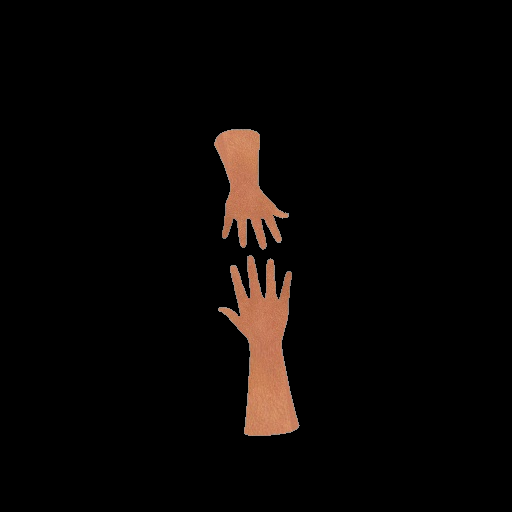

In [30]:
# @title Create datasource and show an example.

from nerfies import datasets
from nerfies import image_utils

datasource_spec = exp_config.datasource_spec
if datasource_spec is None:
    datasource_spec = {
        'type': exp_config.datasource_type,
        'data_dir': data_dir,
    }
datasource = datasets.from_config(
  datasource_spec,
  #image_scale=exp_config.image_scale,
  image_scale=1,
  use_appearance_id=model_config.use_appearance_metadata,
  use_camera_id=model_config.use_camera_metadata,
  use_warp_id=model_config.use_warp,
  random_seed=exp_config.random_seed)

show_image(datasource.load_rgb(datasource.train_ids[0]))

In [40]:
# @title Initialize model
# @markdown Defines the model and initializes its parameters.

from flax.training import checkpoints
from nerfies import models
from nerfies import model_utils
from nerfies import schedules
from nerfies import training


rng = random.PRNGKey(exp_config.random_seed)
np.random.seed(exp_config.random_seed + jax.host_id())
devices = jax.devices()

learning_rate_sched = schedules.from_config(train_config.lr_schedule)
warp_alpha_sched = schedules.from_config(train_config.warp_alpha_schedule)
elastic_loss_weight_sched = schedules.from_config(
    train_config.elastic_loss_weight_schedule)

rng, key = random.split(rng)
params = {}
model, params['model'] = models.nerf(
    key,
    model_config,
    batch_size=train_config.batch_size,
    num_appearance_embeddings=len(datasource.appearance_ids),
    num_camera_embeddings=len(datasource.camera_ids),
    num_warp_embeddings=len(datasource.warp_ids),
    near=datasource.near,
    far=datasource.far,
    use_warp_jacobian=train_config.use_elastic_loss,
    use_weights=train_config.use_elastic_loss)

optimizer_def = optim.Adam(learning_rate_sched(0))
optimizer = optimizer_def.create(params)
state = model_utils.TrainState(
    optimizer=optimizer,
    warp_alpha=warp_alpha_sched(0))
scalar_params = training.ScalarParams(
    learning_rate=learning_rate_sched(0),
    elastic_loss_weight=elastic_loss_weight_sched(0),
    background_loss_weight=train_config.background_loss_weight)
logging.info('Restoring checkpoint from %s', checkpoint_dir)
#state = checkpoints.restore_checkpoint(checkpoint_dir, state,step=1000)
state = checkpoints.restore_checkpoint(checkpoint_dir, state)
step = state.optimizer.state.step + 1
state = jax_utils.replicate(state, devices=devices)
del params

Restoring checkpoint from logs/a-hands-1/checkpoints
Restoring checkpoint from logs/a-hands-1/checkpoints/checkpoint_175000


In [41]:
# @title Define pmapped render function.

import functools
from nerfies import evaluation
from importlib import reload  

devices = jax.devices()


def _model_fn(key_0, key_1, params, rays_dict, alpha):
  out = model.apply({'params': params},
                    rays_dict,
                    warp_alpha=alpha,
                    rngs={
                        'coarse': key_0,
                        'fine': key_1
                    },
                    mutable=False)
  return jax.lax.all_gather(out, axis_name='batch')

pmodel_fn = jax.pmap(
    # Note rng_keys are useless in eval mode since there's no randomness.
    _model_fn,
    # key0, key1, params, rays_dict, alpha
    in_axes=(0, 0, 0, 0, 0),
    devices=devices,
    donate_argnums=(3,),  # Donate the 'rays' argument.
    axis_name='batch',
)

render_fn = functools.partial(evaluation.render_image,
                              model_fn=pmodel_fn,
                              device_count=len(devices),
                              chunk=eval_config.chunk)

In [42]:
# @title Load cameras.

from nerfies import utils


test_camera_paths = datasource.glob_cameras(Path(data_dir, 'camera'))
#test_camera_paths = datasource.glob_cameras('dataset/syn-eagled-/camera/')
test_cameras = utils.parallel_map(datasource.load_camera, test_camera_paths, show_pbar=True)

100%|███████████████████████████████████████████████████| 150/150 [00:00<00:00, 1592.91it/s]


In [13]:
# @title Render video frames.
import ipyplot
from nerfies import visualization as viz

rng = rng + jax.host_id()  # Make random seed separate across hosts.
keys = random.split(rng, len(devices))

results = []
for i in range(len(test_cameras)):
 # if i%10!=0 or i>100:continue
  print(f'Rendering frame {i+1}/{len(test_cameras)}')
  camera = test_cameras[i]
  batch = datasets.camera_to_rays(camera)
  batch['metadata'] = {
      'appearance': i*jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32),
      'warp': i*jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32),
  }

  pred_color, pred_depth, pred_depth_med, pred_acc = render_fn(state, batch, rng=rng)
  results.append((pred_color, pred_depth, pred_acc))
  pred_depth_viz = viz.colorize(pred_depth.squeeze(), cmin=datasource.near, cmax=datasource.far, invert=True)
  ##break

Rendering frame 1/150
	Rendering ray batch: 0/16384


/private/home/gengshany/.conda/envs/nerfies/lib/python3.8/site-packages/jax/lib/xla_bridge.py:382: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


	Rendering ray batch: 8192/16384
Rendering took 81.2
Rendering frame 2/150
	Rendering ray batch: 0/16384
	Rendering ray batch: 8192/16384
Rendering took 1.11
Rendering frame 3/150
	Rendering ray batch: 0/16384
	Rendering ray batch: 8192/16384


KeyboardInterrupt: 

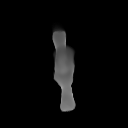

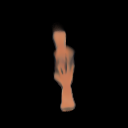

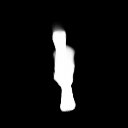

In [14]:
show_image(np.array(pred_depth[:,:,0]))
show_image(np.array(pred_color))
show_image(np.array(pred_acc[:,:,0]))

In [15]:
# @title Show rendered video.

fps = 10  # @param {type:'number'}

frames = []
for rgb, depth,acc in results:
  depth_viz = viz.colorize(depth.squeeze(), cmin=datasource.near, cmax=datasource.far, invert=True)
  acc_viz = viz.colorize(acc.squeeze())

  frame = np.concatenate([rgb, depth_viz], axis=1)

  frames.append(image_utils.image_to_uint8(frame))

show_video(frames, fps=fps)

In [43]:
from jax import tree_util
import time
from importlib import reload  
reload(models)

model, _ = models.nerf_mesh(
    key,
    model_config,
    batch_size=train_config.batch_size,
    num_appearance_embeddings=len(datasource.appearance_ids),
    num_camera_embeddings=len(datasource.camera_ids),
    num_warp_embeddings=len(datasource.warp_ids),
    near=datasource.near,
    far=datasource.far,
    use_warp_jacobian=train_config.use_elastic_loss,
    use_weights=train_config.use_elastic_loss)

def _model_fn(key_0, key_1, params, rays_dict, alpha):
  out = model.apply({'params': params},
                    rays_dict,
                    warp_alpha=alpha,
                    rngs={
                        'coarse': key_0,
                        'fine': key_1
                    },
                    mutable=False)
  return jax.lax.all_gather(out, axis_name='batch')

pmodel_fn = jax.pmap(
    # Note rng_keys are useless in eval mode since there's no randomness.
    _model_fn,
    # key0, key1, params, rays_dict, alpha
    in_axes=(0, 0, 0, 0, 0),
    devices=devices,
    donate_argnums=(3,),  # Donate the 'rays' argument.
    axis_name='batch',
)

device_count=len(devices)
chunk=eval_config.chunk
model_fn = pmodel_fn


_, key_0, key_1 = jax.random.split(rng, 3)
key_0 = jax.random.split(key_0, device_count)
key_1 = jax.random.split(key_1, device_count)
host_id = jax.host_id()

In [44]:
def extract_mesh(bs_pts, chunk, rays_dict, device_count, key_0, key_1, state):
    occ = []
    for i in range(0, bs_pts, chunk):
        #logging.info('\tRendering ray batch: %d/%d', i, num_rays)
        # pylint: disable=cell-var-from-loop
        chunk_slice_fn = lambda x: x[i:i + chunk]
        chunk_rays_dict = tree_util.tree_map(chunk_slice_fn, rays_dict)
        num_chunk_rays = chunk_rays_dict['query_xyz'].shape[0]
        remainder = num_chunk_rays % device_count
        if remainder != 0:
          padding = device_count - remainder
          # pylint: disable=cell-var-from-loop
          chunk_pad_fn = lambda x: jnp.pad(x, ((0, padding), (0, 0)), mode='edge')
          chunk_rays_dict = tree_util.tree_map(chunk_pad_fn, chunk_rays_dict)
        else:
          padding = 0
        # After padding the number of chunk_rays is always divisible by
        # host_count.
        per_host_rays = num_chunk_rays // jax.host_count()
        chunk_rays_dict = tree_util.tree_map(
            lambda x: x[(host_id * per_host_rays):((host_id + 1) * per_host_rays)],
            chunk_rays_dict)
        chunk_rays_dict = utils.shard(chunk_rays_dict, device_count)

        model_out = model_fn(
            key_0,
            key_1,
            state.optimizer.target['model'],
            chunk_rays_dict,
            state.warp_alpha)
        occ.append(utils.unshard(model_out['alpha'][0], padding))
    occ = jnp.concatenate(occ, axis=0)

    vol_o = np.asarray(occ.reshape((grid_size, grid_size, grid_size)))
    return vol_o

In [45]:
import trimesh
import mcubes
import cv2
import shutil

#outseqname = 'nerfies_%s'%(seqname)
outseqname = '%s'%(seqname)
target_dir='/private/home/gengshany/code/vid2shape/logdir/baseline-%s/'%outseqname
! rm -rf "$target_dir"
os.mkdir(target_dir)

In [46]:
bound=(datasource.far-datasource.near)/2 # hands
#bound=(datasource.far-datasource.near)/4 # cat 807
#bound=(datasource.far-datasource.near)/16 # eagle, cat_905
#bound=(datasource.far-datasource.near) / 8 # ama

frame_len=len(test_cameras)
#render_len=15
render_len=frame_len
grid_size = 128
#grid_size = 12
#threshold = 0
threshold = 100

pts = np.linspace(-bound, bound, grid_size).astype(np.float32)
query_yxz = np.stack(np.meshgrid(pts, pts, pts), -1)  # (y,x,z)
query_yxz = query_yxz.reshape(-1, 3)
query_xyz = np.concatenate([query_yxz[:,1:2], query_yxz[:,0:1], query_yxz[:,2:3]],-1)
#query_xyz[:,-1] *= -1

bs_pts = query_xyz.shape[0]
points = query_xyz[:,None]

for tidx in range(0,render_len):
    tidxf = int(tidx/render_len*frame_len)
    print(tidxf)
    metadata={}
    metadata['appearance'] = tidxf* np.ones((points.shape[0],1)).astype(int)
    metadata['warp'] = tidxf*np.ones((points.shape[0],1)).astype(int)
    rays_dict={'query_xyz': query_xyz, 'metadata': metadata}

    vol_o = extract_mesh(bs_pts, chunk, rays_dict, device_count, key_0, key_1, state)

    print('fraction occupied:', (vol_o > threshold).astype(float).mean())
    vertices, triangles = mcubes.marching_cubes(vol_o, threshold)
    vertices = (vertices - grid_size/2)/grid_size*2
    vertices = vertices * bound

    mesh = trimesh.Trimesh(vertices, triangles)
    camtxt = np.zeros((4,4))
    camtxt[:3,:3] = test_cameras[tidxf].orientation
    camtxt[:3,3] = camtxt[:3,:3].dot(-test_cameras[tidxf].position[:,None])[:,0]
    camtxt[3,:2] = [test_cameras[tidxf].focal_length, 
                    test_cameras[tidxf].focal_length]
    camtxt[3,2:] = test_cameras[tidxf].principal_point
    

    mesh.export('%s/%s-mesh-%05d.obj'%(target_dir,outseqname,tidx))
    np.savetxt('%s/%s-cam-%05d.txt'%(target_dir,outseqname,tidx), camtxt)

0
fraction occupied: 0.001049041748046875
1
fraction occupied: 0.0010609626770019531
2
fraction occupied: 0.0010585784912109375
3
fraction occupied: 0.0010600090026855469
4
fraction occupied: 0.0010600090026855469
5
fraction occupied: 0.0010609626770019531
6
fraction occupied: 0.0010619163513183594
7
fraction occupied: 0.0010585784912109375
8
fraction occupied: 0.0010528564453125
9
fraction occupied: 0.0010504722595214844
10
fraction occupied: 0.0010509490966796875
11
fraction occupied: 0.0010538101196289062
12
fraction occupied: 0.0010576248168945312
13
fraction occupied: 0.0010542869567871094
14
fraction occupied: 0.001049041748046875
15
fraction occupied: 0.0010480880737304688
16
fraction occupied: 0.0010423660278320312
17
fraction occupied: 0.0010390281677246094
18
fraction occupied: 0.0010380744934082031
19
fraction occupied: 0.0010333061218261719
20
fraction occupied: 0.0010371208190917969
21
fraction occupied: 0.0010333061218261719
22
fraction occupied: 0.0010371208190917969
23
